Validus IV Func model case study. I have taken spot as the 1st of may and used that as the date to build all forward points. I have only gone 1 year out for brevity but if I extended the example data the files should work as intended.

to install packages use.

python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps validus-pkg-test

In [1]:
## first want to import data and packages created 
import validus_pkg_test
import validus_pkg_test.SV_MC
import validus_pkg_test.Fund_Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

#excel files containing relevant data
CF_data = pd.read_excel('ValidusIV_CF.xlsx', index_col=0)
CCY_data = pd.read_excel('ForwardCurves.xlsx',index_col = 0)
returns_data = pd.read_excel('Data_extract_nonlogged.xlsx',index_col=0)

In [2]:
# this file is a simple cash flow of the fund broken out into different ccys USD GBP and EUR
CF_data.head()

,USD,GBP,EUR
CashFlow Date,,,
2019-04-01,-100000,-100000,-100000
2019-05-01,0,10000,0
2019-06-01,10000,1000,0
2019-07-01,10000,1000,0
2019-08-01,0,1000,0


In [3]:
#this file created from the market data provided using the forward points and linearly interpolating 
#for missing values 
# 
CCY_data.head()

,EURUSD,GBPUSD,EURGBP
CCY,,,
Spot,1.121300,1.310300,0.855840
1M,1.124141,1.312270,0.856722
2M,1.127050,1.314264,0.857634
3M,1.129946,1.316255,0.858539
4M,1.133012,1.318318,0.859521


In [4]:
# this file is the non-logged return data and the implied volatility for each date and CCY pair from market data
returns_data.head()

,EURUSD return,GBPUSD return,EURGBP return,Implied Volatility EURUSD,Implied Volatility GBPUSD,Implied Volatility EURGBP
2000-01-05,0.242813,0.403423,-0.182685,20.00,13.0,7.0
2000-01-06,0.067823,0.292220,-0.222806,20.00,13.0,7.0
2000-01-07,-0.319520,-0.491684,0.175453,20.00,13.0,7.0
2000-01-10,-0.378825,-0.115903,-0.270679,11.75,13.0,7.0
2000-01-11,0.780031,0.616832,0.143690,12.25,13.0,7.0


The first step I will present is the implementation of a stochastic volatility model to come up with volatililty forecasts which willbe used to give a potential impact scenario analysis for the funds FX exposure. I will use the last 100 days of return data to build my model.

The model is as follows
Xn = Xn-1  * rho  + sigma * Vn,
Yn =  beta* exp( Xn /2 ) * Wn

with Xn representing volatility of asset and Yn the returns, Vn and Wn are N(0,1) distributions and rho,sigma and beta are paramters to be estimated.

For my purposes in order to keep things simple I have assumed beta = 1.

In [20]:
# get last 100 days data
GBPUSD = returns_data['GBPUSD return'][4927:5026]
EURUSD = returns_data['EURUSD return'][4927:5026]


# The below function implements a maximum likelihood method for ewtimating the parameters 
# in a stochastic volatility model this will take some time to run if re-run

## model parameter estimate for EURUSD
x = validus_pkg_test.SV_MC.maximum_like(60,60,200,EURUSD)

##model parameter estimate for GBPUSD
y = validus_pkg_test.SV_MC.maximum_like(60,60,200,GBPUSD)

Text(0.5, 1.0, 'EURUSD volatility estimate past 100 days')

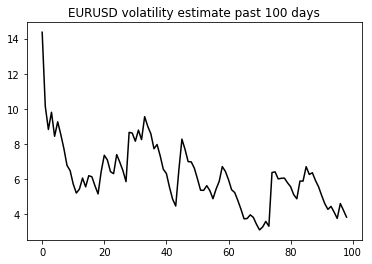

In [6]:
## here I have used a function that estimates the underlying volatility based on observed returns data 
p = validus_pkg_test.SV_MC.SIR_Stoch_vol(N=1000,Y=EURUSD,rho=x['rho'],beta=1,sigma=x['sigma'])
plt.plot(np.exp(p[0]/2)*np.sqrt(252),color="black")
plt.title('EURUSD volatility estimate past 100 days')


Text(0.5, 1.0, 'GBPUSD volatility estimate past 100 days')

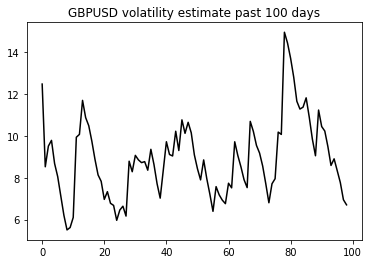

In [7]:
q = validus_pkg_test.SV_MC.SIR_Stoch_vol(N=1000,Y=GBPUSD,rho=y['rho'],beta=1,sigma=y['sigma'])
plt.plot(np.exp(q[0]/2)*np.sqrt(252),color="black")
plt.title('GBPUSD volatility estimate past 100 days')

Text(0.5, 1.0, 'EURUSD volatility estimate next year')

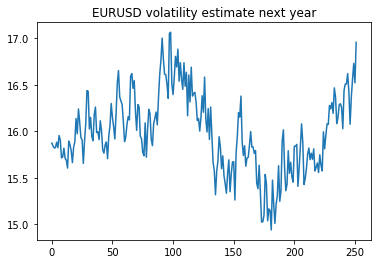

In [9]:
## using the model parameters that we have estimated above run volatility model 1000 times out to 1 year 
# to get estimate for future volatility
p = validus_pkg_test.SV_MC.stochastic_volatility_run(N=1000,T=252,rho=x['rho'],beta=1,sigma=x['sigma'],x0=0)
plt.plot(np.sqrt(252)*np.exp(p/2))
plt.title('EURUSD volatility estimate next year')

Text(0.5, 1.0, 'GBPUSD volatility estimate next year')

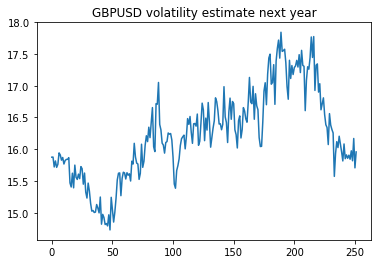

In [10]:
q = validus_pkg_test.SV_MC.stochastic_volatility_run(N=1000,T=252,rho=y['rho'],beta=1,sigma=y['sigma'],x0=0)
plt.plot(np.sqrt(252)*np.exp(q/2))
plt.title('GBPUSD volatility estimate next year')

From plots it looks like the model does well at estimating past levels of volatility but falls down estimating into the future with the levels of volatility looking far too high, this is could be due to many factors most likely the poor estimating procedure and the significant MC variance produced by the SIR method. Smooothing algorithms and using many more sample paths would likely improve the models performance and get different MLEs also allowing the beta parameter to vary would be a good idea but far more computationally exspensive. Using an MLE procdure such as Stochastic gradient descent would ease the burden but to do so would require alot of smoothing or increase the number of paths N significantly.

In [11]:
## this funciton returns 95% lower bound of percentage movements based on forecasted volatility 
### should really return the upper and lower bound as will depend on what CCY you view as functional 
m = validus_pkg_test.SV_MC.vol_curve(p)
n = validus_pkg_test.SV_MC.vol_curve(q)

## create the stressed scenarios 
vol_scenarios = pd.DataFrame({'EURUSD':m,'GBPUSD':n})
vol_scenarios.loc[-1] = [1,1]  # adding a row
vol_scenarios.index = vol_scenarios.index + 1  # shifting index
vol_scenarios = vol_scenarios.sort_index()
vol_scenarios

,EURUSD,GBPUSD
0,1.000000,1.000000
1,0.910182,0.910182
2,0.872173,0.875779
3,0.845150,0.853253
4,0.817144,0.823575
5,0.796532,0.797064
6,0.770768,0.780359
7,0.751730,0.758465
8,0.754323,0.731065
9,0.731900,0.713586


Now using the second file in the package Fund_Model which allows for the creation of Fund classes, I will demonstrate below the functionality and the use of the curves found above for analysis.

In [12]:
# need to pass some cash flow data, a functional currency and some forward fx curves
Validus4 = validus_pkg_test.Fund_Model.Fund(CF_data,'USD',CCY_data)

In [13]:
Validus4.cashflows.head()

,USD,GBP,EUR
CashFlow Date,,,
2019-04-01,-100000,-100000,-100000
2019-05-01,0,10000,0
2019-06-01,10000,1000,0
2019-07-01,10000,1000,0
2019-08-01,0,1000,0


In [14]:
Validus4.ccy_curves.head()

,EURUSD,GBPUSD,EURGBP
CCY,,,
Spot,1.121300,1.310300,0.855840
1M,1.124141,1.312270,0.856722
2M,1.127050,1.314264,0.857634
3M,1.129946,1.316255,0.858539
4M,1.133012,1.318318,0.859521


In [15]:
# simple function to return the IRR of a given CCY cashflow
Validus4.IRR('EUR')

0.02094921447218434

In [16]:
## this returns the total cashflow in the functional CCY which can be used to calculate a total IRR
total = Validus4.totalCF(Validus4.ccy_curves)
total

CashFlow Date
2019-04-01   -343160.000000
2019-05-01     13122.700000
2019-06-01     11314.264000
2019-07-01     11316.255000
2019-08-01      1318.318000
2019-09-01      1320.105000
2019-10-01     45989.910000
2019-11-01     85783.893333
2019-12-01     57959.673333
2020-01-01     69500.900000
2020-02-01     43028.285000
2020-03-01     33109.570000
2020-04-01     11595.427500
dtype: float64

In [17]:
# can return the total irr 
l = np.irr(total)
l*100

1.5198154117977092

Text(0.5, 1.0, 'GBPUSD 95% forecast')

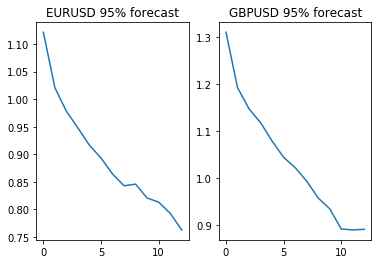

In [18]:
## now using the volatility scenario created to test how the cashflows and hence IRR is affected

# this returns stressed CCY curves can see GBP and EUR weakening against USD
y = Validus4.scenario_analysis(vol_scenarios)
plt.subplot(1,2,1)
plt.plot(y['EURUSD'])
plt.title('EURUSD 95% forecast')
plt.subplot(1,2,2)
plt.plot(y['GBPUSD'])
plt.title('GBPUSD 95% forecast')


In [19]:

k = np.irr(Validus4.totalCF(y))
k *100
# the IRR is now negative so the scenario impact here is dramatic

-1.1976090549102314

The results here are pretty dramtic but this is to be expected due to the very high volatilities my model predicted, my model is most definately wrong and not very useful at this stage but with better estimation methods and time hopefully it could become more relevant and representative of reality.